# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions

## Create processes

In [2]:
def createProcessesConstant_a(N, a_true):
    """
    Function to create an nth order auto regressive (AR) process
    
    a_true can be of any order
    """
    
    order = len(a_true) # get the order of the AR process
    
    ex = np.random.randn(N) # random noise
    
    S = ex.copy()
    
    for n in range(order, N):
        x = np.array([S[n-i] for i in range(1, order + 1)]) # create samples to calculate the AR process
        S[n] = np.dot(x, a_true) + ex[n] # create the AR process
        
    return ex, S

def createProcessesVarying_a(N, a_initial, alpha, omega):
    """
    Fix a_initial to be of second order, or length 2 for simplicity of implementation
    """

    
    ex = np.random.randn(N)
    
    S = ex.copy()
    
    A = np.zeros((N, 2))
    a0 = a_initial[0]
    a1 = a_initial[1]
    
    for i in range(N):
        A[i, 0] = a0 + alpha * np.cos(2*np.pi*5*i/N) # vary the coefficient of the AR process
        A[i, 1] = a1 + alpha * np.sin(np.pi*5*i/N)
    
    
    for n in range(2, N):
        
        a_iter = A[n, :] # get the nth coefficient
        
        x = np.array([S[n-1], S[n-2]]) # previous two values as it is a 2nd order process
        S[n] = np.dot(x, a_iter) + ex[n] # calculate AR process
        
    return ex, S, A

# combines the previous two into a single function with a flag as to which approach to use
def createProcess(N, a, n_cycles = 5, alpha=0.1, constant = True):
    
    ex = np.random.randn(N)
    
    if constant:
        A = np.repeat(a, N).reshape(-1,N).T
        
    else:
        A = np.zeros((N, 2))
        a0 = a[0]
        a1 = a[1]

        for i in range(N):
            A[i, 0] = a0 + alpha * np.cos(2*np.pi*n_cycles*i/N)
            A[i, 1] = a1 + alpha * np.sin(np.pi*n_cycles*i/N)
            
    S = ex.copy()
    
    for n in range(2, N):
        
        a_iter = A[n, :]
        
        x = np.array([S[n-1], S[n-2]])
        S[n] = np.dot(x, a_iter) + ex[n]
        
    return ex, S, A
    
    
        
        

## Kalman Filter

In [3]:
def kalmanFilter(y,ex, beta=0.0001, alpha=0.001, gamma = 0.2, n_samples_estimate=10, initial_theta = None):
    
    N = len(ex)
    
    # Initialsation
    x = np.zeros((2, 1))
    
    if initial_theta is None:
        theta_n1_n1 = np.random.randn(2,1)
    else:
        theta_n1_n1 = initial_theta.reshape((2,1))
    
    
    # Hyper parameters, tuned and observe effects
    P_n1_n1 = alpha*np.eye(2)
    R = gamma*np.std(ex[0:n_samples_estimate])
#     R = 200
    Q = beta*np.eye(2)
        
    
    theta_conv = np.zeros([2,N])
    
    ePlot = list()
    
    for n in range(2,N):
        
        x[0] = y[n-1]
        x[1] = y[n-2]
        
        theta_n_n1 = theta_n1_n1.copy()
        P_n_n1 = P_n1_n1 + Q
        
        yh = theta_n_n1.T @ x
        en = y[n] - yh
        
        ePlot.append(en)
        
        
        den = x.T @ P_n_n1 @ x + R
        
        kn = P_n_n1 @ x / den
        # Posterior update
        #
        theta_n_n = theta_n_n1 + kn * en
        P_n_n = (np.eye(2) - kn @ x.T) @ P_n_n1
        # Save
        theta_conv[0,n] = theta_n_n[0]
        theta_conv[1,n] = theta_n_n[1]
        
        # Remember for next step
        #
        theta_n1_n1 = theta_n_n.copy()
        P_n1_n1 = P_n_n.copy()
        
    
    print(P_n_n)
        
    return theta_n_n, theta_conv

        
        
        

## Plotting function

In [4]:
def plotProcesses(excitation, AR_process, save = False, f = None):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6))
    plt.tight_layout()
    ax[0].plot(excitation)
    ax[0].grid(True)
    ax[0].set_title("Random Excitation Signal")
    ax[1].plot(AR_process, color='m')
    ax[1].grid(True)
    ax[1].set_title("Autoregressive Process")
    
    if save and f is not None:
        fig.savefig(f)
    
    plt.show()

# Implementation

In [9]:
N = 1000

In [10]:
a1 = np.array([1.2,-0.4])

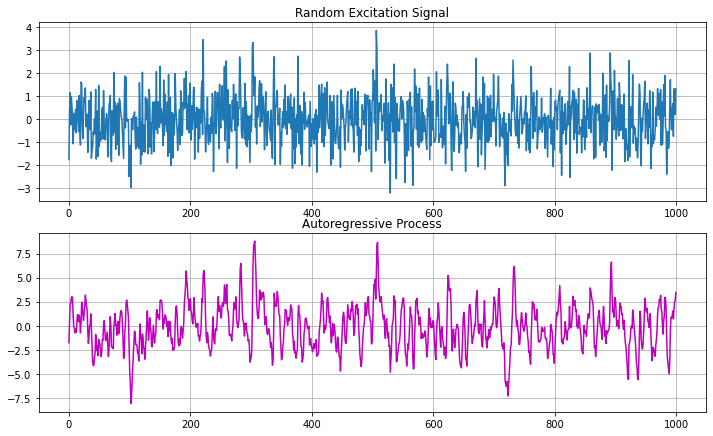

In [15]:
np.random.seed(100)

ex1_c, S1_c, _ = createProcess(N, a1)
plotProcesses(ex1_c, S1_c)

[[ 0.00300338 -0.00171963]
 [-0.00171963  0.00305805]]


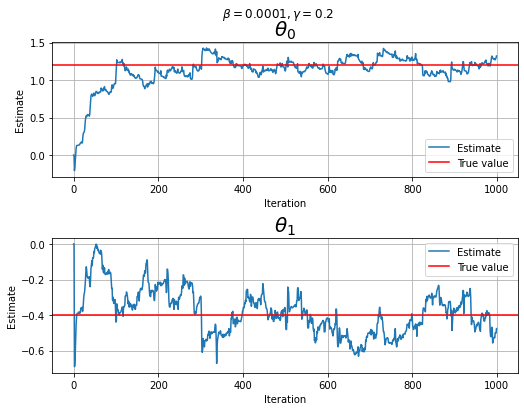

In [16]:
alpha_c = 0.001
beta_c = 0.0001
gamma_c = 0.2

b = 'small'
g = 'above'



theta1_c, theta_plot1_c = kalmanFilter(S1_c, ex1_c, alpha = alpha_c, beta = beta_c, gamma = gamma_c)

fig_thetaEst, ax_thetaEst = plt.subplots(nrows = 2, figsize=(8,6))
fig_thetaEst.tight_layout(pad = 4)

for i in range(len(ax_thetaEst)):
    ax_thetaEst[i].plot(theta_plot1_c[i], label = 'Estimate')
    ax_thetaEst[i].axhline(a1[i], c = 'r', label = 'True value')
    ax_thetaEst[i].set_xlabel('Iteration')
    ax_thetaEst[i].set_ylabel('Estimate')
    ax_thetaEst[i].legend()
    ax_thetaEst[i].grid()
    ax_thetaEst[i].set_title(f'$\\theta_{i}$', fontsize = 20)
    
fig_thetaEst.suptitle(f'$\\beta = {beta_c}, \\gamma = {gamma_c}$')
# fig_thetaEst.savefig('theta_const_beta_' + b +'.pdf')
    
plt.show()

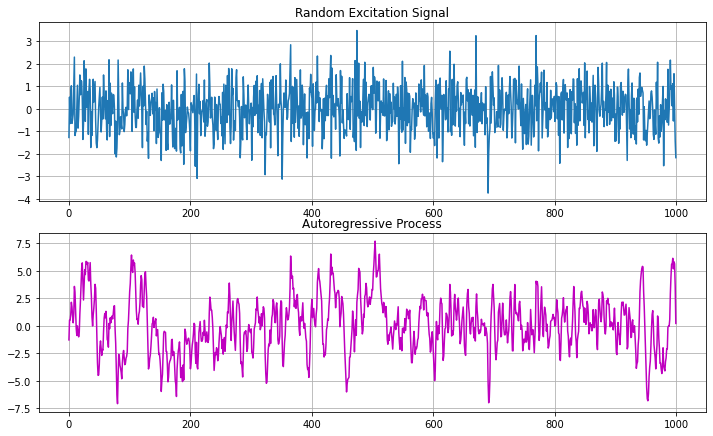

In [11]:
# np.random.seed(100)

ex1_v, S1_v, A_true = createProcess(N, a1, constant=False, n_cycles = 2)
plotProcesses(ex1_v, S1_v)

[[ 0.00291123 -0.00174385]
 [-0.00174385  0.00299807]]


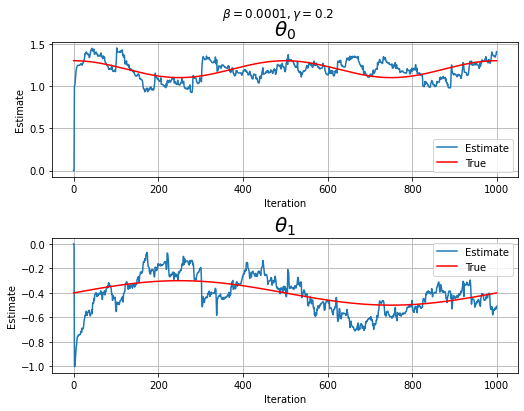

In [33]:
np.random.seed(100)

alpha_v = 0.001
beta_v = 0.0001
gamma_v = 0.2

b = 'standard'
g = 'standard'

theta1_v, theta_plot1_v = kalmanFilter(S1_v, ex1_v, alpha = alpha_v, beta = beta_v, gamma = gamma_v, initial_theta=np.array([[1,-1]]))

fig_thetaEst, ax_thetaEst = plt.subplots(nrows = 2, figsize=(8,6))
fig_thetaEst.tight_layout(pad = 4)

for i in range(len(ax_thetaEst)):
    ax_thetaEst[i].plot(theta_plot1_v[i], label = 'Estimate')
    ax_thetaEst[i].plot(A_true[:, i], label = 'True', c = 'r')
    ax_thetaEst[i].set_xlabel('Iteration')
    ax_thetaEst[i].set_ylabel('Estimate')
    ax_thetaEst[i].legend()
    ax_thetaEst[i].grid()
    ax_thetaEst[i].set_title(f'$\\theta_{i}$', fontsize = 20)
    
fig_thetaEst.suptitle(f'$\\beta = {beta_v}, \\gamma = {gamma_v}$')

fig_thetaEst.savefig('theta_vary_beta_' + b +'.pdf')
plt.show()

[[ 0.00489415 -0.00380198]
 [-0.00380198  0.00480082]]


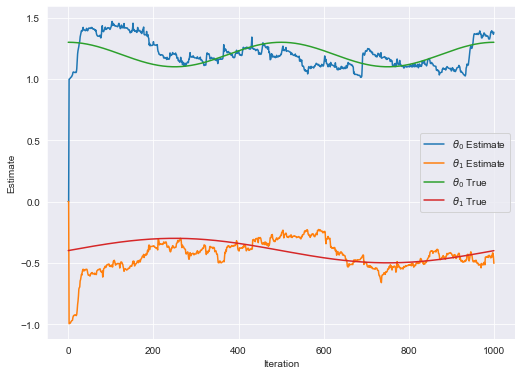

In [12]:
# np.random.seed(100)
sns.set_style('darkgrid')

alpha_v = 0.001
beta_v = 0.0001
gamma_v = 0.5

b = 'standard'
g = 'standard'

theta1_v, theta_plot1_v = kalmanFilter(S1_v, ex1_v, alpha = alpha_v, beta = beta_v, gamma = gamma_v, initial_theta=np.array([[1,-1]]))

fig, ax = plt.subplots(figsize=(8,6))
fig.tight_layout(pad = 4)


ax.plot(theta_plot1_v[0], label = f'$\\theta_0$ Estimate')
ax.plot(theta_plot1_v[1], label = f'$\\theta_1$ Estimate')
ax.plot(A_true[:, 0], label = f'$\\theta_0$ True')
ax.plot(A_true[:, 1], label = f'$\\theta_1$ True')
ax.set_xlabel('Iteration')
ax.set_ylabel('Estimate')
ax.legend()



ax.set_xlabel('Iteration')
ax.set_ylabel('Estimate')
ax.legend()
# fig.savefig('KF_partFilt_CW.pdf')
plt.show()